### Burnt Area Segmentation

#### Loading Dataset - Turkish Wild Fires  
**Dataset Info:**

- Contains 25,563 multispectral Sentinel-2 images (128×128 px, 3 bands) and corresponding binary masks.  
- Images are georeferenced using UTM and stored in GeoTIFF format with 16-bit unsigned integer values (0–65,535).  
- Masks are 8-bit binary images where burned areas are labeled as 1 (foreground) and non-burned areas as 0 (background).  
- Supports analysis of vegetation change, fire spread, and post-fire decision-making.

**Citation:**  
Al-Dabbagh, Ali; Ilyas, Muhammad (2022), “Deep Learning and Remote Sensing Dataset For Turkey's Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery”, Mendeley Data, V1, doi: [10.17632/hgctmx9y6c.1](https://doi.org/10.17632/hgctmx9y6c.1)


Downloading Data to Drive - RUN ONCE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

base_dir = '/content/drive/My Drive/turkish-dataset'
os.makedirs(base_dir, exist_ok=True)

!wget -nc https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hgctmx9y6c-1.zip
!unzip -n hgctmx9y6c-1.zip

!apt-get install -y unrar

rar_path = "Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset.rar"
!unrar x -o+ "{rar_path}" "Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/"

import shutil

source_dir = "Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset"
target_dir = os.path.join(base_dir, "Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery", "Dataset")

if not os.path.exists(target_dir):
    shutil.move(source_dir, target_dir)

image_dir = os.path.join(target_dir, "Train Images")
mask_dir = os.path.join(target_dir, "Train Masks")

print("Image directory:", image_dir)
print("Mask directory:", mask_dir)


Loading Dataset from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hgctmx9y6c-1.zip
!unzip hgctmx9y6c-1.zip
!apt-get install unrar
!unrar x "Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset.rar" \
         "Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/"

Streaming output truncated to the last 5000 lines.
Extracting  Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset/Train Masks/Image (55).tif      99%  OK 
Extracting  Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset/Train Masks/Image (550).tif      99%  OK 
Extracting  Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset/Train Masks/Image (5500).tif      99%  OK 
Extracting  Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset/Train Masks/Image (5501).tif      99%  OK 
Extracting  Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset/Train Masks/Image (5502).tif      99%  OK 
Extracting  Deep Learning and Remote Sensi

In [3]:
!pip install rasterio --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 107.7 MB/s eta 0:00:00


Visualizing Some of the Data

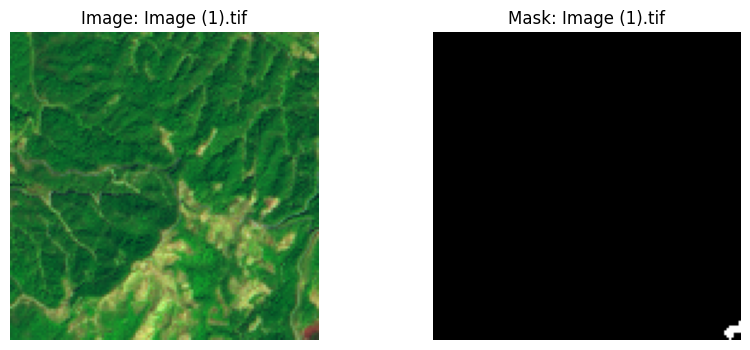

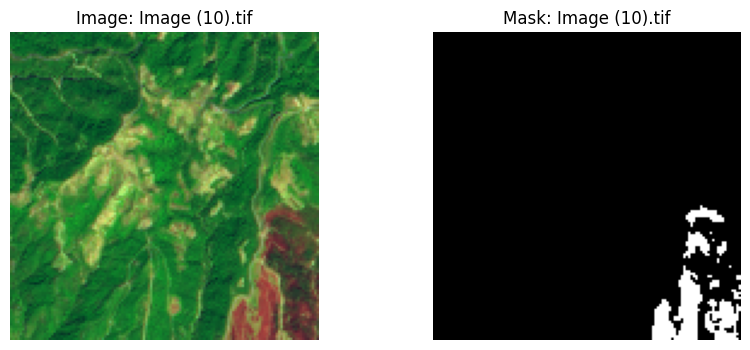

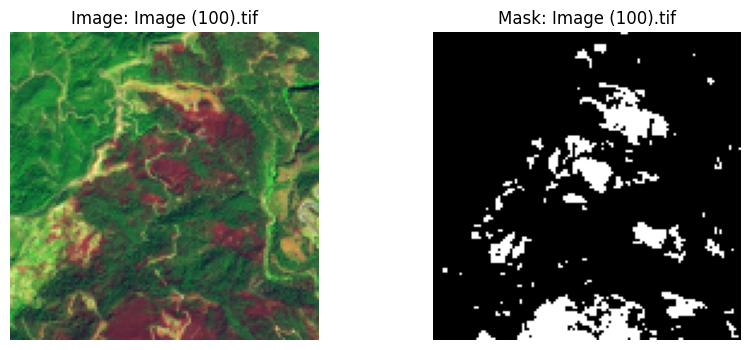

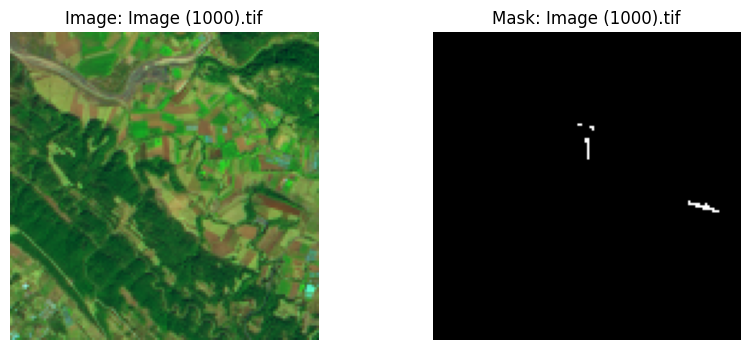

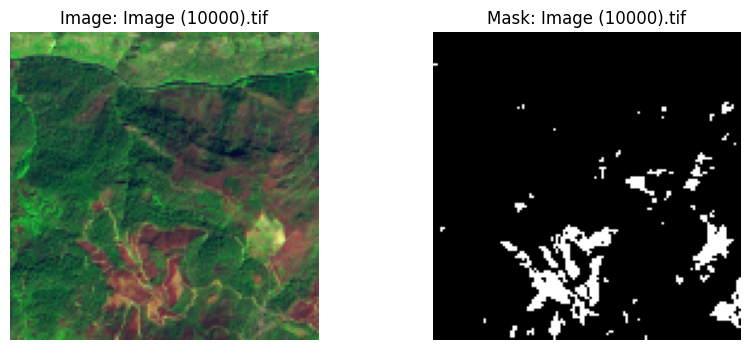

In [4]:
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np

image_dir = "Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset/Train Images"
mask_dir = "Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset/Train Masks"

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

for i in range(5):
    image_path = os.path.join(image_dir, image_files[i])
    mask_path = os.path.join(mask_dir, mask_files[i])

    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3]) if src.count >= 3 else np.stack([src.read(1)] * 3)
        image = np.transpose(image, (1, 2, 0))
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)

    with rasterio.open(mask_path) as src:
        mask = src.read(1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {image_files[i]}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask: {mask_files[i]}")
    plt.axis("off")

    plt.show()


In [5]:
import os
import random
import re
from tqdm import tqdm

import numpy as np
import rasterio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Define custom PyTorch `Dataset` class for loading multispectral Sentinel-2 wildfire imagery and corresponding mask file.

In [6]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

class WildfireDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_filenames, mask_filenames, transform=None):

        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.transform = transform

        if len(self.image_filenames) != len(self.mask_filenames):
            raise ValueError("Number of images and masks must be the same")

        for img_f, msk_f in zip(self.image_filenames, self.mask_filenames):
             if natural_sort_key(img_f) != natural_sort_key(msk_f):
                 print(f"Mismatch {img_f} vs {msk_f}")

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_filenames[idx])

        try:
            with rasterio.open(img_name) as src:
                if src.count >= 3:
                    image = src.read([1, 2, 3]).astype(np.float32)
                else:
                    img_data = src.read(1).astype(np.float32)
                    image = np.stack([img_data] * 3, axis=0)

                min_val = image.min()
                max_val = image.max()
                if max_val - min_val > 1e-6:
                    image = (image - min_val) / (max_val - min_val)
                else:
                    image = image - min_val

            with rasterio.open(mask_name) as src:
                mask = src.read(1).astype(np.float32)
                mask = np.expand_dims(mask, axis=0)

            image_tensor = torch.from_numpy(image)
            mask_tensor = torch.from_numpy(mask)

            if self.transform:
                pass

            return image_tensor, mask_tensor

        except Exception as e:
            print(f"Error loading sample {idx}: {img_name} / {mask_name}")
            print(f"Error message: {e}")
            raise e


base_dir = "Deep Learning and Remote Sensing Dataset For Turkeys Wildfire 2021 Multispectral Sentinel-2 Satellite Imagery/Dataset"
image_dir = os.path.join(base_dir, "Train Images")
mask_dir = os.path.join(base_dir, "Train Masks")

all_image_files = sorted(os.listdir(image_dir), key=natural_sort_key)
all_mask_files = sorted(os.listdir(mask_dir), key=natural_sort_key)

if len(all_image_files) != len(all_mask_files):
    print("Error: Mismatch in number of image and mask files!")
else:
    mismatched = False
    for i, (img_f, msk_f) in enumerate(zip(all_image_files, all_mask_files)):
        img_num = re.search(r'\((\d+)\)', img_f)
        msk_num = re.search(r'\((\d+)\)', msk_f)
        if not img_num or not msk_num or img_num.group(1) != msk_num.group(1):
            print(f"Mismatch found at index {i}: {img_f} vs {msk_f}")
            mismatched = True
    if not mismatched:
        print("Image and Mask filenames seem to correspond correctly after sorting.")


indices = list(range(len(all_image_files)))
train_indices, test_indices = train_test_split(indices, test_size=0.3, random_state=42)

train_image_files = [all_image_files[i] for i in train_indices]
train_mask_files = [all_mask_files[i] for i in train_indices]
test_image_files = [all_image_files[i] for i in test_indices]
test_mask_files = [all_mask_files[i] for i in test_indices]

print(f"Total samples: {len(all_image_files)}")
print(f"Training samples: {len(train_image_files)}")
print(f"Test samples: {len(test_image_files)}")


train_dataset = WildfireDataset(image_dir, mask_dir, train_image_files, train_mask_files)
test_dataset = WildfireDataset(image_dir, mask_dir, test_image_files, test_mask_files)

BATCH_SIZE = 32

def collate_fn_skip_error(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if not batch: return None, None
    return torch.utils.data.dataloader.default_collate(batch)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("\nTesting DataLoader...")
try:
    images, masks = next(iter(train_loader))
    print("Batch loaded successfully:")
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    print("Image dtype:", images.dtype)
    print("Mask dtype:", masks.dtype)
    print("Image min/max:", images.min().item(), images.max().item())
    print("Mask min/max:", masks.min().item(), masks.max().item())
except Exception as e:
    print(f"Error testing DataLoader: {e}")
    print("There might be an issue with file loading or processing in the Dataset class.")

Image and Mask filenames seem to correspond correctly after sorting.
Total samples: 25563
Training samples: 17894
Test samples: 7669

Testing DataLoader...
Batch loaded successfully:
Image batch shape: torch.Size([32, 3, 128, 128])
Mask batch shape: torch.Size([32, 1, 128, 128])
Image dtype: torch.float32
Mask dtype: torch.float32
Image min/max: 0.0 1.0
Mask min/max: 0.0 1.0


Define a hybrid semantic segmentation model that combines a **ResNet-18 encoder** with a **UNet-style decoder**. It's tailored for tasks like wildfire burned area detection using satellite imagery.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm



class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Up(nn.Module):
    """Upscaling then double conv - Corrected channel logic"""
    def __init__(self, ch_in_below, ch_skip, ch_out, bilinear=True):
        super().__init__()
        self.bilinear = bilinear
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            conv_in_channels = ch_in_below + ch_skip
            self.conv = DoubleConv(conv_in_channels, ch_out)
        else:
            up_out_channels = ch_in_below // 2
            self.up = nn.ConvTranspose2d(ch_in_below, up_out_channels, kernel_size=2, stride=2)
            conv_in_channels = up_out_channels + ch_skip
            self.conv = DoubleConv(conv_in_channels, ch_out)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        if diffY != 0 or diffX != 0:
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)


class ResNetUNet(nn.Module):
    def __init__(self, n_classes=1, bilinear=True):
        super(ResNetUNet, self).__init__()
        self.n_classes = n_classes
        self.bilinear = bilinear

        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        self.initial_conv = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        )
        self.initial_pool = resnet.maxpool

        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.up4 = Up(ch_in_below=512, ch_skip=256, ch_out=256, bilinear=bilinear)
        self.up3 = Up(ch_in_below=256, ch_skip=128, ch_out=128, bilinear=bilinear)
        self.up2 = Up(ch_in_below=128, ch_skip=64, ch_out=64, bilinear=bilinear)
        self.up1 = Up(ch_in_below=64, ch_skip=64, ch_out=64, bilinear=bilinear)

        self.up0 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear' if bilinear else 'nearest', align_corners=True if bilinear else None),
            nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.outc = OutConv(32, n_classes)

    def forward(self, x):
        x_initial = self.initial_conv(x)
        x_pooled = self.initial_pool(x_initial)

        e1 = self.encoder1(x_pooled)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        d4 = self.up4(e4, e3)
        d3 = self.up3(d4, e2)
        d2 = self.up2(d3, e1)
        d1 = self.up1(d2, x_initial)

        d0 = self.up0(d1)

        logits = self.outc(d0)
        return logits

model = ResNetUNet(n_classes=1, bilinear=True).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'\nThe ResNetUNet model has {count_parameters(model):,} trainable parameters')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]



The ResNetUNet model has 14,404,257 trainable parameters


Define training and eval routines

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


def compute_iou(preds, targets):
    smooth = 1e-6
    preds = preds.bool()
    targets = targets.bool()
    intersection = (preds & targets).float().sum()
    union = (preds | targets).float().sum()
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()



def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0
    progress_bar = tqdm(loader, desc="Training", leave=False)
    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    return epoch_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    total_iou = 0.0
    num_batches = 0

    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Evaluating", leave=False)
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct_pixels += (preds == masks.bool()).sum().item()
            total_pixels += masks.numel()
            total_iou += compute_iou(preds, masks)
            num_batches += 1

    avg_loss = epoch_loss / len(loader)
    accuracy = 100.0 * correct_pixels / total_pixels if total_pixels > 0 else 0.0
    avg_iou = total_iou / num_batches if num_batches > 0 else 0.0
    return avg_loss, accuracy, avg_iou



Training for 5 EPOCHS

In [9]:
NUM_EPOCHS = 5

train_losses = []
test_losses = []
test_accuracies = []
test_ious = []

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_accuracy, test_iou = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_ious.append(test_iou)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: \t"
          f"Train Loss: {train_loss:.4f} \t"
          f"Test Loss: {test_loss:.4f} \t"
          f"Test Accuracy: {test_accuracy:.2f}% \t"
          f"IoU: {test_iou:.4f}")

print("DONE TRAINING")


Epoch 1/5: 	Train Loss: 0.2250 	Test Loss: 0.1653 	Test Accuracy: 96.06% 	IoU: 0.7847


Epoch 2/5: 	Train Loss: 0.1315 	Test Loss: 0.1021 	Test Accuracy: 97.51% 	IoU: 0.8460


Epoch 3/5: 	Train Loss: 0.0939 	Test Loss: 0.0764 	Test Accuracy: 97.77% 	IoU: 0.8617


Epoch 4/5: 	Train Loss: 0.0755 	Test Loss: 0.0649 	Test Accuracy: 97.78% 	IoU: 0.8641


Epoch 5/5: 	Train Loss: 0.0630 	Test Loss: 0.0589 	Test Accuracy: 97.89% 	IoU: 0.8631
DONE TRAINING


Plotting Results

Plotting Metrics

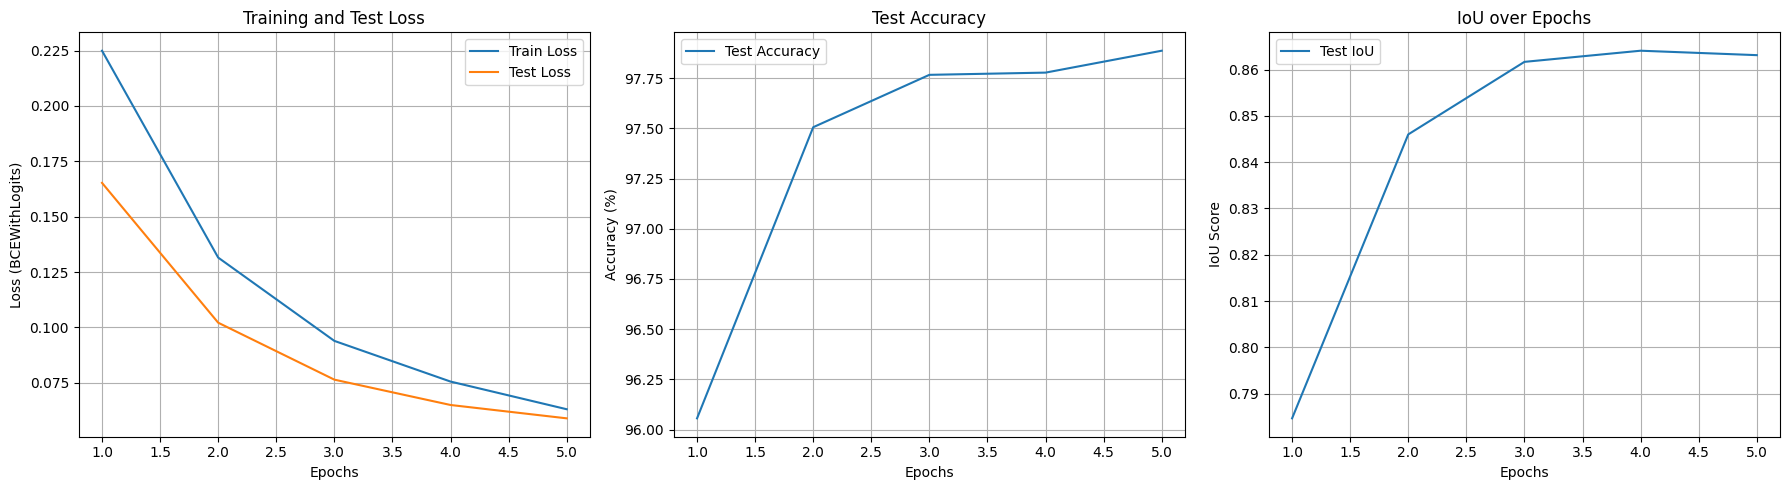

In [10]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (BCEWithLogits)')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_ious, label='Test IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.title('IoU over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Visualizing the Predictions from the model

Saving Model

In [11]:
torch.save(model.state_dict(), "resnet_unet_burned_area.pth")
print("Model saved to resnet_unet_burned_area.pth")


Model saved to resnet_unet_burned_area.pth


Visualizing Predictions and Evaluating on the test Set


Visualizing Predictions on Test Set (ResNetUNet)...


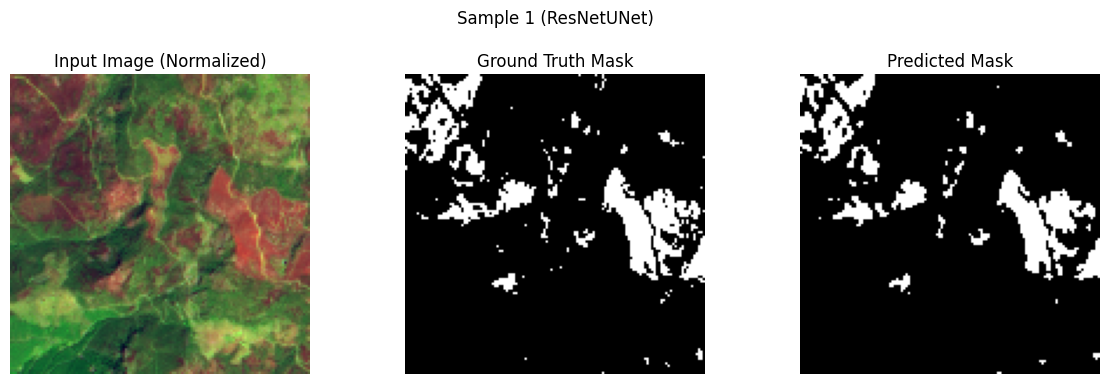

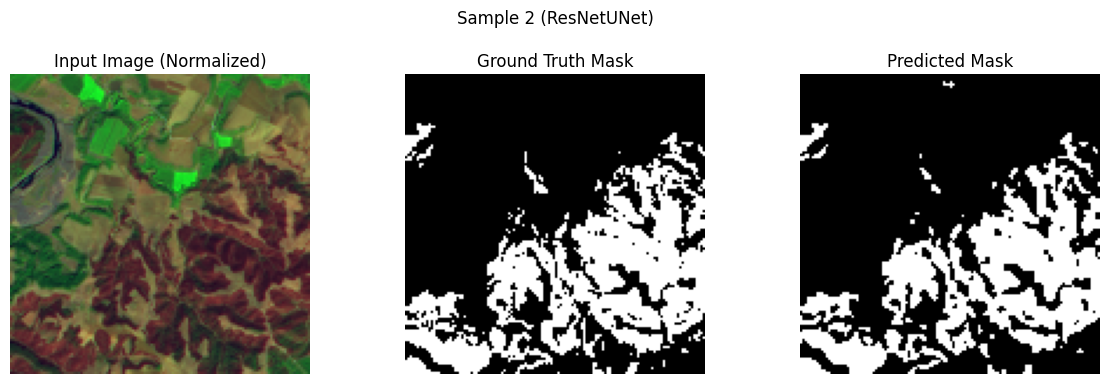

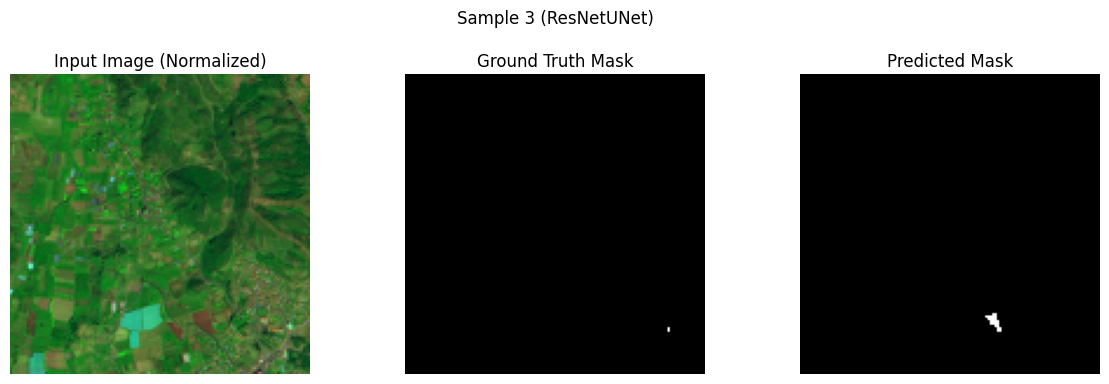

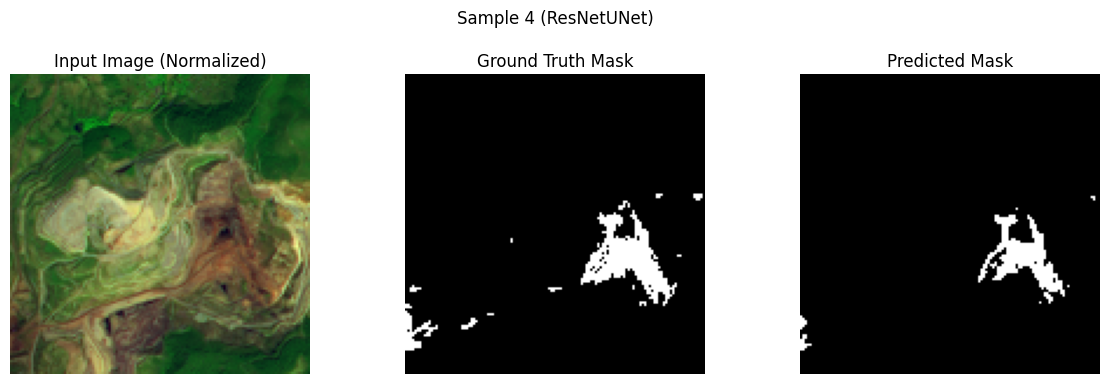

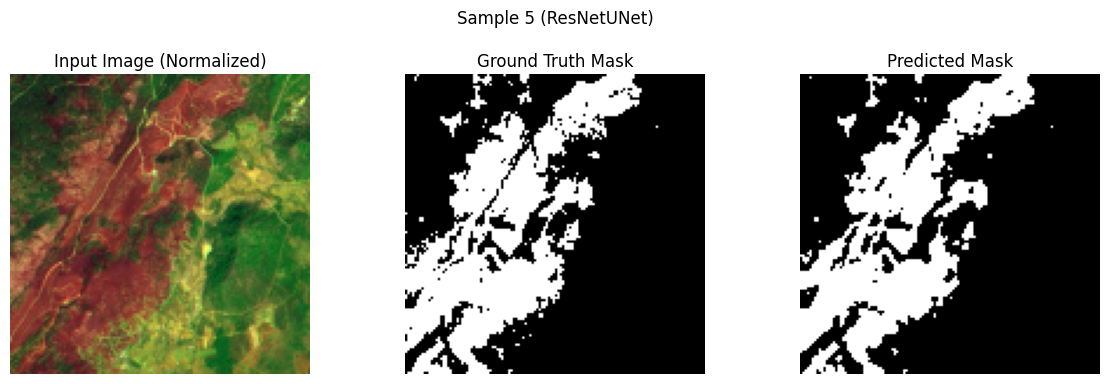


Final Test Loss (ResNetUNet): 0.0589
Final Test Accuracy (ResNetUNet): 97.89%
Final Test IOU (ResNetUNet): 0.86%


In [13]:
def visualize_predictions(model, loader, device, num_samples=5):
    model.eval()
    samples_shown = 0
    with torch.no_grad():
        loader_iter = iter(loader)
        while samples_shown < num_samples:
            try:
                images, masks = next(loader_iter)
            except StopIteration:
                print("Reached end of loader before showing desired samples.")
                break

            images = images.to(device)
            masks = masks.cpu().numpy().squeeze(1)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu() > 0.5
            preds_np = preds.numpy().squeeze(1)

            images_np = images.cpu().numpy()

            batch_size = images_np.shape[0]
            for i in range(batch_size):
                if samples_shown >= num_samples:
                    break

                image = np.transpose(images_np[i], (1, 2, 0))
                mask_true = masks[i]
                mask_pred = preds_np[i]
                image = np.clip(image, 0, 1)

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title("Input Image (Normalized)")
                plt.axis('off')
                plt.subplot(1, 3, 2)
                plt.imshow(mask_true, cmap='gray')
                plt.title("Ground Truth Mask")
                plt.axis('off')
                plt.subplot(1, 3, 3)
                plt.imshow(mask_pred, cmap='gray')
                plt.title("Predicted Mask")
                plt.axis('off')
                plt.suptitle(f"Sample {samples_shown + 1} (ResNetUNet)")
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()
                samples_shown += 1

print("\nVisualizing Predictions on Test Set (ResNetUNet)...")
visualize_predictions(model, test_loader, device, num_samples=5)

final_test_loss, final_test_accuracy, IOU_score = evaluate(model, test_loader, criterion, device)
print(f"\nFinal Test Loss (ResNetUNet): {final_test_loss:.4f}")
print(f"Final Test Accuracy (ResNetUNet): {final_test_accuracy:.2f}%")
print(f"Final Test IOU (ResNetUNet): {IOU_score:.2f}%")